In [248]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [249]:
df = pd.read_csv('/content/gurgaon_houses_and_flats_combined.csv', on_bad_lines = 'skip')

df.head()


,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,additionalroom,floornum,facing,agepossession,nearbylocations,furnishdetails,features,area_in_sq_ft
0,flat,Maa Bhagwati Residency,Sector 7,0.45,5000.0,900.0,Carpet area: 900 (83.61 sq.m.),2,2,1,not available,4,west,1 to 5 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Pear...","['3 Fan', '4 Light', '1 Wardrobe', 'No AC', 'N...","['Feng Shui / Vaastu Compliant', 'Security / F...",NaN
1,flat,Apna Enclave,Sector 3,0.50,7692.0,650.0,Carpet area: 650 (60.39 sq.m.),2,2,1,not available,1,west,10+ Year Old,"['Chintapurni Mandir', 'Sheetla Mata Mandir', ...","['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '1 Ge...","['Security / Fire Alarm', 'Maintenance Staff',...",NaN
2,flat,Tulsiani Easy In Homes,Sohna Road,0.40,6722.0,595.0,Carpet area: 595 (55.28 sq.m.),2,2,3,not available,12,na,0 to 1 Year Old,"['Huda City Metro', 'Golf Course extn road', '...",NaN,"['Power Back-up', 'Feng Shui / Vaastu Complian...",NaN
3,flat,Smart World Orchard,Sector 61,1.47,12250.0,1200.0,Carpet area: 1200 (111.48 sq.m.),2,2,2,study room,2,na,Dec 2023,"['Sector 55-56 Metro station', 'Bestech Centra...",NaN,"['Security / Fire Alarm', 'Private Garden / Te...",NaN
4,flat,Parkwood Westend,Sector 92,0.70,5204.0,1345.0,Super Built up area 1345(124.95 sq.m.),2,2,3,study room,5,na,Under Construction,"['Yadav Clinic', 'Bangali Clinic', 'Dr. J. S. ...",[],NaN,NaN


# 1.areawithtype

In [250]:
df[['area_in_sq_ft','areawithtype']].sample(5)

,area_in_sq_ft,areawithtype
1290,NaN,Super Built up area 2685(249.44 sq.m.)Built Up...
1480,NaN,Super Built up area 1572(146.04 sq.m.)
176,NaN,Super Built up area 1262(117.24 sq.m.)
3369,1302.4319,Built Up area: 1297 (120.5 sq.m.)
1333,NaN,Super Built up area 1565(145.39 sq.m.)


In [251]:
# Function to extract Super Built-up area

def get_super_built_up_area(text):
    match = re.search(r'Super Built up area\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

# Function to extract other areas (Built Up or Carpet)

def get_area(text, area_type):
    match = re.search(area_type + r':?\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

# Function to check if area is in sq.m. and convert to sqft

def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(rf'{area_value}.*\((\d+\.?\d*) sq.m.\)', text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # Conversion factor
    return area_value

# Function to extract Plot Area

def extract_plot_area(text):
    match = re.search(r'Plot area\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None


In [252]:
df['super_built_up_area'] = df['areawithtype'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areawithtype'], x['super_built_up_area']), axis=1)

df['built_up_area'] = df['areawithtype'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areawithtype'], x['built_up_area']), axis=1)

df['carpet_area'] = df['areawithtype'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areawithtype'], x['carpet_area']), axis=1)

df['plot_area'] = df['areawithtype'].apply(extract_plot_area)

# Round off all areas to two decimal places
df['super_built_up_area'] = df['super_built_up_area'].round(2)
df['built_up_area'] = df['built_up_area'].round(2)
df['carpet_area'] = df['carpet_area'].round(2)
df['plot_area'] = df['plot_area'].round(2)



In [253]:
house = df[df['property_type'].str.contains('house')]

house_null_index = house[house['built_up_area'].isnull() & house['plot_area'].notnull()].index

df.loc[house_null_index, 'built_up_area'] = house.loc[house_null_index, 'plot_area']

In [254]:
def convert_scale(row):

    if np.isnan(row['built_up_area']):
        return row['built_up_area']

    else:
        ratio = np.round(row['area_in_sq_ft'] / row['built_up_area'])

        if ratio == 9:

           # 9 * sq.yard = sq.ft
           return  row['built_up_area'] * 9.0184

        elif ratio == 11:
           # 10.7 * sq.m = sq.ft
           return row['built_up_area'] * 10.7

        else:
           return row['built_up_area']


df['built_up_area'] = df.select_dtypes(include = 'number').apply(convert_scale, axis=1)


In [255]:
df.loc[2002,'super_built_up_area'] = 89*10.7

In [256]:
df.loc[2000:2010][['areawithtype','super_built_up_area', 'built_up_area', 'carpet_area']]


,areawithtype,super_built_up_area,built_up_area,carpet_area
2000,Built Up area: 681 (63.27 sq.m.)Carpet area: 5...,NaN,681.0,581.0
2001,Super Built up area 850(78.97 sq.m.),850.0,NaN,NaN
2002,Carpet area: 1260 (117.06 sq.m.),952.3,NaN,1260.0
2003,Carpet area: 3212 (298.4 sq.m.),NaN,NaN,3212.0
2004,Built Up area: 2300 (213.68 sq.m.),NaN,2300.0,NaN
2005,Carpet area: 2040 (189.52 sq.m.),NaN,NaN,2040.0
2006,Carpet area: 1436 (133.41 sq.m.),NaN,NaN,1436.0
2007,Carpet area: 394 (36.6 sq.m.),NaN,NaN,394.0
2008,Super Built up area 1827(169.73 sq.m.),1827.0,NaN,NaN
2009,Built Up area: 670 (62.25 sq.m.)Carpet area: 5...,NaN,670.0,569.0


In [257]:
df.loc[1657][['area_in_sq_ft','areawithtype','super_built_up_area', 'built_up_area', 'carpet_area']]


,1657
area_in_sq_ft,NaN
areawithtype,Carpet area: 1889 (175.49 sq.m.)
super_built_up_area,NaN
built_up_area,NaN
carpet_area,1889.0


In [258]:
df.loc[1657]['areawithtype']

'Carpet area: 1889 (175.49 sq.m.)'

In [259]:
df['super_built_up_area'].describe()

,super_built_up_area
count,1925.000000
mean,1916.048582
std,768.313942
min,89.000000
25%,1457.000000
50%,1822.000000
75%,2215.000000
max,10000.000000


In [260]:
df.loc[1657]['areawithtype']

'Carpet area: 1889 (175.49 sq.m.)'

In [261]:
145*9

1305

In [262]:
df[['price_in_cr', 'property_type', 'area_in_sq_ft', 'areawithtype', 'super_built_up_area', 'built_up_area', 'carpet_area']].tail(5)


,price_in_cr,property_type,area_in_sq_ft,areawithtype,super_built_up_area,built_up_area,carpet_area
3834,5.50,house,1797.5713,Plot area 200(167.23 sq.m.),NaN,1803.6800,NaN
3835,4.25,house,1345.4875,Plot area 150(125.42 sq.m.),NaN,1352.7600,NaN
3836,4.50,house,1345.4875,Plot area 150(125.42 sq.m.),NaN,1352.7600,NaN
3837,3.25,house,979.5149,Plot area 109(91.14 sq.m.),NaN,983.0056,NaN
3838,3.60,house,2432.6414,Plot area 270(225.75 sq.m.),NaN,2434.9680,NaN


# 2.additional_room

In [263]:
df.head(2)

,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,...,facing,agepossession,nearbylocations,furnishdetails,features,area_in_sq_ft,super_built_up_area,built_up_area,carpet_area,plot_area
0,flat,Maa Bhagwati Residency,Sector 7,0.45,5000.0,900.0,Carpet area: 900 (83.61 sq.m.),2,2,1,...,west,1 to 5 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Pear...","['3 Fan', '4 Light', '1 Wardrobe', 'No AC', 'N...","['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,NaN,NaN,900.0,NaN
1,flat,Apna Enclave,Sector 3,0.50,7692.0,650.0,Carpet area: 650 (60.39 sq.m.),2,2,1,...,west,10+ Year Old,"['Chintapurni Mandir', 'Sheetla Mata Mandir', ...","['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '1 Ge...","['Security / Fire Alarm', 'Maintenance Staff',...",NaN,NaN,NaN,650.0,NaN


In [264]:
df['additionalroom'].value_counts()

,count
additionalroom,
not available,1618
servant room,705
study room,249
others,229
pooja room,167
...,...
"store room,study room",1
"study room,store room,pooja room",1
"servant room,pooja room,store room,study room",1


In [265]:
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

for j in new_cols:
    df[j] = df['additionalroom'].str.contains(j).astype(int)


In [266]:
df[['additionalroom','study room', 'servant room', 'store room', 'pooja room', 'others']].head(5)


,additionalroom,study room,servant room,store room,pooja room,others
0,not available,0,0,0,0,0
1,not available,0,0,0,0,0
2,not available,0,0,0,0,0
3,study room,1,0,0,0,0
4,study room,1,0,0,0,0


In [267]:
df[df['society'] == 'HCBS Sports Ville']

,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,...,area_in_sq_ft,super_built_up_area,built_up_area,carpet_area,plot_area,study room,servant room,store room,pooja room,others
11,flat,HCBS Sports Ville,Sohna Road,0.29,5587.0,519.0,Carpet area: 519 (48.22 sq.m.),2,2,1,...,NaN,NaN,NaN,519.00,NaN,0,0,0,0,0
82,flat,HCBS Sports Ville,Sohna Road,0.28,3768.0,743.0,Built Up area: 743 (69.03 sq.m.)Carpet area: 6...,2,2,1,...,NaN,NaN,743.00,643.00,NaN,0,0,0,0,0
101,flat,HCBS Sports Ville,Sohna Road,0.24,7407.0,324.0,Carpet area: 324 (30.1 sq.m.),1,1,2,...,NaN,NaN,NaN,324.00,NaN,0,0,0,0,0
190,flat,HCBS Sports Ville,Sohna Road,0.30,3970.0,756.0,Built Up area: 743 (69.03 sq.m.)Carpet area: 5...,2,2,1,...,NaN,NaN,743.00,519.00,NaN,0,0,0,0,0
191,flat,HCBS Sports Ville,Sohna Road,0.38,5067.0,750.0,Built Up area: 750 (69.68 sq.m.)Carpet area: 6...,2,2,2,...,NaN,NaN,750.00,650.00,NaN,0,0,0,0,0
1893,flat,HCBS Sports Ville,Sohna Road,0.20,2666.0,750.0,Super Built up area 750(69.68 sq.m.)Built Up a...,2,2,1,...,NaN,750.0,743.00,600.00,NaN,0,0,0,0,0
2011,flat,HCBS Sports Ville,Sector 2,0.35,4375.0,800.0,Built Up area: 800 (74.32 sq.m.)Carpet area: 6...,2,2,2,...,NaN,NaN,800.00,600.00,NaN,0,0,0,0,0
2045,flat,HCBS Sports Ville,Sohna Road,0.20,4219.0,474.0,Built Up area: 473.99 (44.04 sq.m.),1,1,1,...,NaN,NaN,474.04,NaN,NaN,0,0,0,0,0
2075,flat,HCBS Sports Ville,Sohna Road,0.22,3142.0,700.0,Carpet area: 700 (65.03 sq.m.),1,1,1,...,NaN,NaN,NaN,700.00,NaN,0,0,0,0,0
2232,flat,HCBS Sports Ville,Sohna Road,0.32,4301.0,744.0,Built Up area: 743.99 (69.12 sq.m.),2,2,1,...,NaN,NaN,744.00,NaN,NaN,0,0,0,0,0


# 3.agepossession

In [268]:
df['agepossession'].value_counts()

,count
agepossession,
1 to 5 Year Old,1678
5 to 10 Year Old,582
0 to 1 Year Old,537
undefined,345
10+ Year Old,317
Under Construction,90
Within 6 months,70
Within 3 months,26
Dec 2023,22


In [269]:
def fixing_age_posession(age):

    if pd.isna(age):
       return 'Undefined'

    elif age in ['0 to 1 Year Old', 'Within 6 months', 'Within 3 months']:
        return 'New Property'

    elif(age == '1 to 5 Year Old'):
        return 'Relatively New'

    elif(age == '5 to 10 Year Old'):
        return 'Moderately Old'

    elif(age == '10+ Year Old'):
        return 'Old'

    else:
        try:
          age = int(age.split(' ')[-1])
          if age >= 2025:
            return 'Under Construction'

          elif 2023 <= age or age <=2024 :
             return 'New Property'

        except:
          return 'Undefined'

In [270]:
df['agepossession'] = df['agepossession'].apply(fixing_age_posession)

In [271]:
df['agepossession'].value_counts()

,count
agepossession,
Relatively New,1678
New Property,783
Moderately Old,582
Undefined,436
Old,317
Under Construction,43


In [272]:
df.columns

Index(['property_type', 'society', 'sector', 'price_in_cr', 'price_per_sqft',
       'area_in_sqft', 'areawithtype', 'bedroom', 'bathroom', 'balcony',
       'additionalroom', 'floornum', 'facing', 'agepossession',
       'nearbylocations', 'furnishdetails', 'features', 'area_in_sq_ft',
       'super_built_up_area', 'built_up_area', 'carpet_area', 'plot_area',
       'study room', 'servant room', 'store room', 'pooja room', 'others'],
      dtype='object')

# 4.furnishdetails

In [273]:
df[df['society'] == 'HCBS Sports Ville']

,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,...,area_in_sq_ft,super_built_up_area,built_up_area,carpet_area,plot_area,study room,servant room,store room,pooja room,others
11,flat,HCBS Sports Ville,Sohna Road,0.29,5587.0,519.0,Carpet area: 519 (48.22 sq.m.),2,2,1,...,NaN,NaN,NaN,519.00,NaN,0,0,0,0,0
82,flat,HCBS Sports Ville,Sohna Road,0.28,3768.0,743.0,Built Up area: 743 (69.03 sq.m.)Carpet area: 6...,2,2,1,...,NaN,NaN,743.00,643.00,NaN,0,0,0,0,0
101,flat,HCBS Sports Ville,Sohna Road,0.24,7407.0,324.0,Carpet area: 324 (30.1 sq.m.),1,1,2,...,NaN,NaN,NaN,324.00,NaN,0,0,0,0,0
190,flat,HCBS Sports Ville,Sohna Road,0.30,3970.0,756.0,Built Up area: 743 (69.03 sq.m.)Carpet area: 5...,2,2,1,...,NaN,NaN,743.00,519.00,NaN,0,0,0,0,0
191,flat,HCBS Sports Ville,Sohna Road,0.38,5067.0,750.0,Built Up area: 750 (69.68 sq.m.)Carpet area: 6...,2,2,2,...,NaN,NaN,750.00,650.00,NaN,0,0,0,0,0
1893,flat,HCBS Sports Ville,Sohna Road,0.20,2666.0,750.0,Super Built up area 750(69.68 sq.m.)Built Up a...,2,2,1,...,NaN,750.0,743.00,600.00,NaN,0,0,0,0,0
2011,flat,HCBS Sports Ville,Sector 2,0.35,4375.0,800.0,Built Up area: 800 (74.32 sq.m.)Carpet area: 6...,2,2,2,...,NaN,NaN,800.00,600.00,NaN,0,0,0,0,0
2045,flat,HCBS Sports Ville,Sohna Road,0.20,4219.0,474.0,Built Up area: 473.99 (44.04 sq.m.),1,1,1,...,NaN,NaN,474.04,NaN,NaN,0,0,0,0,0
2075,flat,HCBS Sports Ville,Sohna Road,0.22,3142.0,700.0,Carpet area: 700 (65.03 sq.m.),1,1,1,...,NaN,NaN,NaN,700.00,NaN,0,0,0,0,0
2232,flat,HCBS Sports Ville,Sohna Road,0.32,4301.0,744.0,Built Up area: 743.99 (69.12 sq.m.),2,2,1,...,NaN,NaN,744.00,NaN,NaN,0,0,0,0,0


In [274]:
all_furnishings = []

for detail in df['furnishdetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishdetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishdetails'] + columns_to_include]

furnishings_df.drop(columns = 'furnishdetails', inplace = True)


In [275]:
furnishings_df.head()

,TV,Chimney,Modular Kitchen,Fan,AC,Microwave,Light,Stove,Geyser,Exhaust Fan,Wardrobe,Fridge,Bed,Water Purifier,Dining Table,Curtains,Sofa,Washing Machine
0,0,0,0,3,0,0,4,0,0,0,1,0,0,0,0,0,0,0
1,0,1,1,4,0,0,3,0,1,1,3,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [276]:
df.columns

Index(['property_type', 'society', 'sector', 'price_in_cr', 'price_per_sqft',
       'area_in_sqft', 'areawithtype', 'bedroom', 'bathroom', 'balcony',
       'additionalroom', 'floornum', 'facing', 'agepossession',
       'nearbylocations', 'furnishdetails', 'features', 'area_in_sq_ft',
       'super_built_up_area', 'built_up_area', 'carpet_area', 'plot_area',
       'study room', 'servant room', 'store room', 'pooja room', 'others',
       'TV', 'Chimney', 'Modular Kitchen', 'Fan', 'AC', 'Microwave', 'Light',
       'Stove', 'Geyser', 'Exhaust Fan', 'Wardrobe', 'Fridge', 'Bed',
       'Water Purifier', 'Dining Table', 'Curtains', 'Sofa',
       'Washing Machine'],
      dtype='object')

In [277]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [278]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [279]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

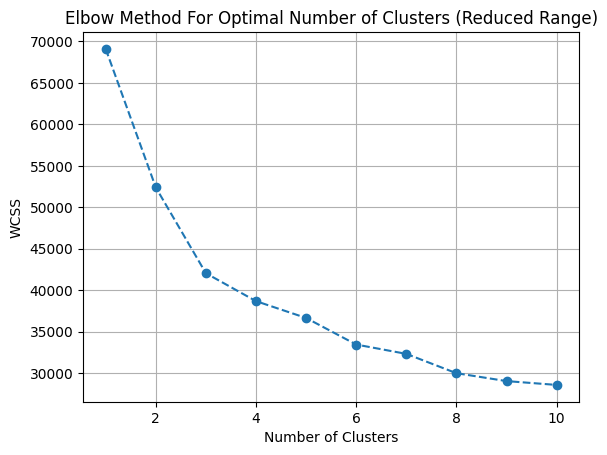

In [280]:
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [281]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [282]:
# df = df.iloc[:,:-18]

In [283]:
df.shape

(3839, 45)

In [284]:
# df = df.iloc[:,:-18]

In [285]:
df['furnishdetails'].isnull().sum()

996

In [286]:
df['furnishing_type'] = cluster_assignments

In [287]:
# df.sample(5)[['furnishdetails','furnishing_type']]

# # 0 -> unfurnished
# # 1 -> semifurnished
# # 2 -> furnished

In [288]:
df['furnishing_type'].unique()

array([0, 2, 1], dtype=int32)

In [289]:
# pd.set_option('display.max_columns', None)

In [290]:
df['furnishing_type'].value_counts()

,count
furnishing_type,
0,2562
2,1068
1,209


In [291]:
df.shape

(3839, 46)

# 5.features

In [292]:
df[['society','features']].head()

,society,features
0,Maa Bhagwati Residency,"['Feng Shui / Vaastu Compliant', 'Security / F..."
1,Apna Enclave,"['Security / Fire Alarm', 'Maintenance Staff',..."
2,Tulsiani Easy In Homes,"['Power Back-up', 'Feng Shui / Vaastu Complian..."
3,Smart World Orchard,"['Security / Fire Alarm', 'Private Garden / Te..."
4,Parkwood Westend,NaN


In [293]:
societies_df = pd.read_csv('/content/societies.csv', on_bad_lines = 'skip')

societies_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Pa...","{'Bajghera Road': '800 Meter', 'Palam Vihar Ha...",https://www.99acres.com/smartworld-one-dxp-sec...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa'..."
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap Un...","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The N...",https://www.99acres.com/m3m-crown-sector-111-g...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Mini Theatre', 'Manicured G..."


In [294]:
societies_df.shape

(247, 7)

In [295]:
df['society'] = df['society'].str.lower()

In [296]:
societies_df['PropertyName'] = societies_df['PropertyName'].str.lower()

In [297]:
temp_df = df[df['features'].isnull()]

temp_df[['society','features']].sample(10)

,society,features
2696,sapphire eighty three,NaN
2587,signature global orchard avenue,NaN
3302,independent,NaN
3191,independent,NaN
3114,shivpuri,NaN
2172,elan the presidential,NaN
2070,tulip violet,NaN
3233,independent,NaN
2112,emaar palm gardens,NaN
3386,independent,NaN


In [298]:
df.shape

(3839, 46)

In [299]:
temp_df.shape # societies where features values are not present here

(658, 46)

In [300]:
societies_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,smartworld one dxp,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Pa...","{'Bajghera Road': '800 Meter', 'Palam Vihar Ha...",https://www.99acres.com/smartworld-one-dxp-sec...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa'..."
1,m3m crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap Un...","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The N...",https://www.99acres.com/m3m-crown-sector-111-g...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Mini Theatre', 'Manicured G..."


In [301]:
temp_df.shape

(658, 46)

In [302]:
df['features'].isnull().sum()

658

In [303]:
x = temp_df.merge(societies_df, left_on = 'society', right_on = 'PropertyName', how = 'left')['TopFacilities']


In [304]:
df.loc[temp_df.index,'features'] = x.values

In [305]:
df['features'].isnull().sum() # after filling df socity features from societies_df


521

In [306]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [307]:
# Convert the string representation of lists in the 'features' column to actual lists

df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)


In [308]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Airy Rooms,Amphitheatre,Badminton Court,Bank Attached Property,Banquet Hall,...,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
879,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,1,1,0,0
926,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,1,1,0,0
2667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [309]:
features_binary_df.shape

(3839, 122)

In [310]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution

weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [311]:
df['luxury_score'] = luxury_score

In [312]:
df.head()

,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,...,Fridge,Bed,Water Purifier,Dining Table,Curtains,Sofa,Washing Machine,furnishing_type,features_list,luxury_score
0,flat,maa bhagwati residency,Sector 7,0.45,5000.0,900.0,Carpet area: 900 (83.61 sq.m.),2,2,1,...,0,0,0,0,0,0,0,0,"[Feng Shui / Vaastu Compliant, Security / Fire...",28
1,flat,apna enclave,Sector 3,0.50,7692.0,650.0,Carpet area: 650 (60.39 sq.m.),2,2,1,...,0,0,0,0,1,0,0,2,"[Security / Fire Alarm, Maintenance Staff, Wat...",37
2,flat,tulsiani easy in homes,Sohna Road,0.40,6722.0,595.0,Carpet area: 595 (55.28 sq.m.),2,2,3,...,0,0,0,0,0,0,0,0,"[Power Back-up, Feng Shui / Vaastu Compliant, ...",36
3,flat,smart world orchard,Sector 61,1.47,12250.0,1200.0,Carpet area: 1200 (111.48 sq.m.),2,2,2,...,0,0,0,0,0,0,0,0,"[Security / Fire Alarm, Private Garden / Terra...",76
4,flat,parkwood westend,Sector 92,0.70,5204.0,1345.0,Super Built up area 1345(124.95 sq.m.),2,2,3,...,0,0,0,0,0,0,0,0,[],0


In [313]:
df.columns

Index(['property_type', 'society', 'sector', 'price_in_cr', 'price_per_sqft',
       'area_in_sqft', 'areawithtype', 'bedroom', 'bathroom', 'balcony',
       'additionalroom', 'floornum', 'facing', 'agepossession',
       'nearbylocations', 'furnishdetails', 'features', 'area_in_sq_ft',
       'super_built_up_area', 'built_up_area', 'carpet_area', 'plot_area',
       'study room', 'servant room', 'store room', 'pooja room', 'others',
       'TV', 'Chimney', 'Modular Kitchen', 'Fan', 'AC', 'Microwave', 'Light',
       'Stove', 'Geyser', 'Exhaust Fan', 'Wardrobe', 'Fridge', 'Bed',
       'Water Purifier', 'Dining Table', 'Curtains', 'Sofa', 'Washing Machine',
       'furnishing_type', 'features_list', 'luxury_score'],
      dtype='object')

In [314]:
df.loc[2002,'super_built_up_area'] = 89*10.7

df['super_built_up_area'].describe()

,super_built_up_area
count,1925.000000
mean,1916.048582
std,768.313942
min,89.000000
25%,1457.000000
50%,1822.000000
75%,2215.000000
max,10000.000000


In [315]:
df.head()

,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,...,Fridge,Bed,Water Purifier,Dining Table,Curtains,Sofa,Washing Machine,furnishing_type,features_list,luxury_score
0,flat,maa bhagwati residency,Sector 7,0.45,5000.0,900.0,Carpet area: 900 (83.61 sq.m.),2,2,1,...,0,0,0,0,0,0,0,0,"[Feng Shui / Vaastu Compliant, Security / Fire...",28
1,flat,apna enclave,Sector 3,0.50,7692.0,650.0,Carpet area: 650 (60.39 sq.m.),2,2,1,...,0,0,0,0,1,0,0,2,"[Security / Fire Alarm, Maintenance Staff, Wat...",37
2,flat,tulsiani easy in homes,Sohna Road,0.40,6722.0,595.0,Carpet area: 595 (55.28 sq.m.),2,2,3,...,0,0,0,0,0,0,0,0,"[Power Back-up, Feng Shui / Vaastu Compliant, ...",36
3,flat,smart world orchard,Sector 61,1.47,12250.0,1200.0,Carpet area: 1200 (111.48 sq.m.),2,2,2,...,0,0,0,0,0,0,0,0,"[Security / Fire Alarm, Private Garden / Terra...",76
4,flat,parkwood westend,Sector 92,0.70,5204.0,1345.0,Super Built up area 1345(124.95 sq.m.),2,2,3,...,0,0,0,0,0,0,0,0,[],0


In [316]:
df.shape

(3839, 48)

In [317]:
def titleized(text):

    if isinstance(text, str):

      return str.title(text)

df['society'] = df['society'].apply(titleized)

In [318]:
df.drop(index = df[df['society'].isin(['On Request','Nul',' ','.','house number B','sonata group housing Gh'])].index, inplace = True)
df.replace('Ss', 'SS', inplace = True, regex = True)
df.replace('SS', 'SS Residency', inplace = True, regex = True)
df.replace('Dlf','DLF', inplace = True, regex = True)
df.replace('Ats','ATS', inplace = True, regex = True)
df.replace('Mgf','MGF', inplace = True, regex = True)
df.replace('Bptp','BPTP', inplace = True, regex = True)
df.replace('Chd','CHD', inplace = True, regex = True)
df.replace('Hcbs','HCBS', inplace = True, regex = True)
df.replace('Gls','GLS', inplace = True, regex = True)
df.replace('Mvn','MVN', inplace = True, regex = True)
df.replace('Sbtl','SBTL', inplace = True, regex = True)
df.replace('G l s','GLS', inplace = True, regex = True)
df.replace('Ild','ILD', inplace = True, regex = True)
df.replace('Aipl','AIPL', inplace = True, regex = True)
df.replace('Avl','AVL', inplace = True, regex = True)
df.replace('Rof','ROF', inplace = True, regex = True)
df.replace('Ansal','Ansal Height', inplace = True, regex = True)
df.replace('My Home','Independent', inplace = True, regex = True)
df.replace('Not Applicable','Independent', inplace = True, regex = True)
df.replace('independent','Independent', inplace = True, regex = True)
df.replace('Independent House','Independent', inplace = True, regex = True)
df.replace('Private House','Independent', inplace = True, regex = True)
df.replace('DLF City Phase','DLF City', inplace = True, regex = True)
df.replace('Afnhb','AFNHB', inplace = True, regex = True)
df.replace('Sbr','Sbr', inplace = True, regex = True)
df['society'].replace(',','', inplace = True, regex = True)
df['society'].replace('/','', inplace = True, regex = True)
df.replace('Rwa','RWA', inplace = True, regex = True)
df['society'].replace('Gurgaon','', inplace = True, regex = True)
df['society'].replace('Gurugram','', inplace = True, regex = True)


In [319]:
df.head()

,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,...,Fridge,Bed,Water Purifier,Dining Table,Curtains,Sofa,Washing Machine,furnishing_type,features_list,luxury_score
0,flat,Maa Bhagwati Residency,Sector 7,0.45,5000.0,900.0,Carpet area: 900 (83.61 sq.m.),2,2,1,...,0,0,0,0,0,0,0,0,"[Feng Shui / Vaastu Compliant, Security / Fire...",28
1,flat,Apna Enclave,Sector 3,0.50,7692.0,650.0,Carpet area: 650 (60.39 sq.m.),2,2,1,...,0,0,0,0,1,0,0,2,"[Security / Fire Alarm, Maintenance Staff, Wat...",37
2,flat,Tulsiani Easy In Homes,Sohna Road,0.40,6722.0,595.0,Carpet area: 595 (55.28 sq.m.),2,2,3,...,0,0,0,0,0,0,0,0,"[Power Back-up, Feng Shui / Vaastu Compliant, ...",36
3,flat,Smart World Orchard,Sector 61,1.47,12250.0,1200.0,Carpet area: 1200 (111.48 sq.m.),2,2,2,...,0,0,0,0,0,0,0,0,"[Security / Fire Alarm, Private Garden / Terra...",76
4,flat,Parkwood Westend,Sector 92,0.70,5204.0,1345.0,Super Built up area 1345(124.95 sq.m.),2,2,3,...,0,0,0,0,0,0,0,0,[],0


In [320]:
df.loc[2002,'super_built_up_area'] = 89*10.7

df['super_built_up_area'].describe()

,super_built_up_area
count,1925.000000
mean,1916.048582
std,768.313942
min,89.000000
25%,1457.000000
50%,1822.000000
75%,2215.000000
max,10000.000000


In [321]:
for i in df.select_dtypes(exclude = 'number').columns.tolist():
    df[i] = df[i].str.strip()

In [322]:
df[df['society'] == 'HCBS Sports Ville']

,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,...,Fridge,Bed,Water Purifier,Dining Table,Curtains,Sofa,Washing Machine,furnishing_type,features_list,luxury_score
11,flat,HCBS Sports Ville,Sohna Road,0.29,5587.0,519.0,Carpet area: 519 (48.22 sq.m.),2,2,1,...,0,0,0,0,0,0,0,0,NaN,44
82,flat,HCBS Sports Ville,Sohna Road,0.28,3768.0,743.0,Built Up area: 743 (69.03 sq.m.)Carpet area: 6...,2,2,1,...,0,0,0,0,0,0,0,0,NaN,38
101,flat,HCBS Sports Ville,Sohna Road,0.24,7407.0,324.0,Carpet area: 324 (30.1 sq.m.),1,1,2,...,0,0,0,0,0,0,0,0,NaN,68
190,flat,HCBS Sports Ville,Sohna Road,0.30,3970.0,756.0,Built Up area: 743 (69.03 sq.m.)Carpet area: 5...,2,2,1,...,0,0,0,0,0,0,0,0,NaN,0
191,flat,HCBS Sports Ville,Sohna Road,0.38,5067.0,750.0,Built Up area: 750 (69.68 sq.m.)Carpet area: 6...,2,2,2,...,0,0,0,0,0,0,0,0,NaN,0
1893,flat,HCBS Sports Ville,Sohna Road,0.20,2666.0,750.0,Super Built up area 750(69.68 sq.m.)Built Up a...,2,2,1,...,0,0,0,0,0,0,0,0,NaN,15
2011,flat,HCBS Sports Ville,Sector 2,0.35,4375.0,800.0,Built Up area: 800 (74.32 sq.m.)Carpet area: 6...,2,2,2,...,0,0,0,0,0,0,0,0,NaN,37
2045,flat,HCBS Sports Ville,Sohna Road,0.20,4219.0,474.0,Built Up area: 473.99 (44.04 sq.m.),1,1,1,...,0,0,0,0,0,0,0,0,NaN,71
2075,flat,HCBS Sports Ville,Sohna Road,0.22,3142.0,700.0,Carpet area: 700 (65.03 sq.m.),1,1,1,...,0,1,0,0,0,1,0,0,NaN,86
2232,flat,HCBS Sports Ville,Sohna Road,0.32,4301.0,744.0,Built Up area: 743.99 (69.12 sq.m.),2,2,1,...,0,0,0,0,0,0,0,0,NaN,109


In [323]:
df.drop(index = df[df['sector'].isin(['rajiv chowk', 'nars', ', delhi ncr'])].index , inplace = True)

df['sector'] = df['sector'].str.title().str.strip()

df['sector'] = df['sector'].str.replace('Sohna Road  Road', 'Sohna Road', regex = True)

# 6.Dropping unnecessary columns

In [324]:
df.columns

Index(['property_type', 'society', 'sector', 'price_in_cr', 'price_per_sqft',
       'area_in_sqft', 'areawithtype', 'bedroom', 'bathroom', 'balcony',
       'additionalroom', 'floornum', 'facing', 'agepossession',
       'nearbylocations', 'furnishdetails', 'features', 'area_in_sq_ft',
       'super_built_up_area', 'built_up_area', 'carpet_area', 'plot_area',
       'study room', 'servant room', 'store room', 'pooja room', 'others',
       'TV', 'Chimney', 'Modular Kitchen', 'Fan', 'AC', 'Microwave', 'Light',
       'Stove', 'Geyser', 'Exhaust Fan', 'Wardrobe', 'Fridge', 'Bed',
       'Water Purifier', 'Dining Table', 'Curtains', 'Sofa', 'Washing Machine',
       'furnishing_type', 'features_list', 'luxury_score'],
      dtype='object')

In [326]:
l1 = ['additionalroom', 'furnishdetails', 'nearbylocations','plot_area', 'features', 'features_list','Exhaust Fan', 'Light', 'Washing Machine', 'AC', 'Microwave',
       'Fridge', 'Modular Kitchen', 'Bed', 'Fan', 'Dining Table', 'Geyser', 'Chimney', 'Sofa', 'Wardrobe', 'Curtains', 'Stove', 'TV','Water Purifier']


df.drop(columns = l1, inplace=True)


In [328]:
df.head()

,property_type,society,sector,price_in_cr,price_per_sqft,area_in_sqft,areawithtype,bedroom,bathroom,balcony,...,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,flat,Maa Bhagwati Residency,Sector 7,0.45,5000.0,900.0,Carpet area: 900 (83.61 sq.m.),2,2,1,...,NaN,NaN,900.0,0,0,0,0,0,0,28
1,flat,Apna Enclave,Sector 3,0.50,7692.0,650.0,Carpet area: 650 (60.39 sq.m.),2,2,1,...,NaN,NaN,650.0,0,0,0,0,0,2,37
2,flat,Tulsiani Easy In Homes,Sohna Road,0.40,6722.0,595.0,Carpet area: 595 (55.28 sq.m.),2,2,3,...,NaN,NaN,595.0,0,0,0,0,0,0,36
3,flat,Smart World Orchard,Sector 61,1.47,12250.0,1200.0,Carpet area: 1200 (111.48 sq.m.),2,2,2,...,NaN,NaN,1200.0,1,0,0,0,0,0,76
4,flat,Parkwood Westend,Sector 92,0.70,5204.0,1345.0,Super Built up area 1345(124.95 sq.m.),2,2,3,...,1345.0,NaN,NaN,1,0,0,0,0,0,0


In [329]:
df.to_csv('gurgaon_houses_and_flats_cleaned.csv', index = False)